In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1366900


In [3]:
count = int(np.ceil(len(df) * 0.2))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,768.700012,NaN,NaN
1,0.0,762.130005,NaN,NaN
2,0.0,762.020020,NaN,NaN
3,0.0,782.520020,NaN,NaN
4,0.0,790.510010,NaN,NaN
...,...,...,...,...
971,0.0,1519.280029,1728.280029,1056.619995
972,0.0,1541.439941,1728.280029,1056.619995
973,0.0,1520.900024,1728.280029,1056.619995
974,0.0,1495.530029,1728.280029,1056.619995


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    signal = 1 is buy, -1 is sell
    initial_money = 10000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 236: cannot sell anything, inventory 0
day 238: cannot sell anything, inventory 0
day 239: cannot sell anything, inventory 0
day 240: cannot sell anything, inventory 0
day 241: cannot sell anything, inventory 0
day 248: cannot sell anything, inventory 0
day 251: cannot sell anything, inventory 0
day 252: cannot sell anything, inventory 0
day 253: cannot sell anything, inventory 0
day 255: cannot sell anything, inventory 0
day 256: cannot sell anything, inventory 0
day 267: cannot sell anything, inventory 0
day 268: cannot sell anything, inventory 0
day 282: cannot sell anything, inventory 0
day 283: cannot sell anything, inventory 0
day 293: cannot sell anything, inventory 0
day 294: cannot sell anything, inventory 0
day 295: cannot sell anything, inventory 0
day 296: cannot sell anything, inventory 0
day 300: cannot sell anything, inventory 0
day 302: cannot sell anything, inventory 0
day 304: cannot sell anything, inventory 0
day 305: cannot sell anything, inventory 0
day 306: ca

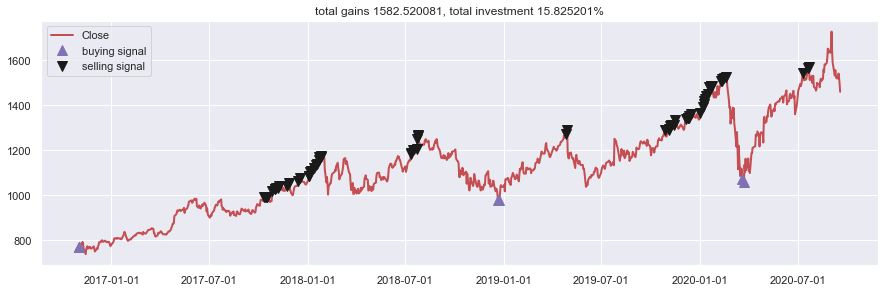

In [6]:
close = df['Close']
dates = pd.to_datetime(df['Date'])
fig = plt.figure(figsize = (15,5))
plt.gcf().autofmt_xdate()
myFmt = md.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.plot(dates,close, color='r', lw=2.,label = 'Close')
plt.plot(dates,close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(dates,close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()